In [1]:
from pylab import *
%matplotlib inline

In [2]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
import caffe
import sys

In [3]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I0127 10:19:11.276899  4018 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0127 10:19:11.277186  4018 convert_mnist_data.cpp:88] A total of 60000 items.
I0127 10:19:11.277289  4018 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0127 10:19:12.352427  4018 convert_mnist_data.cpp:108] Processed 60000 files.
I0127 10:19:12.360935  4019 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0127 10:19:12.361186  4019 convert_mnist_data.cpp:88] A total of 10000 items.
I0127 10:19:12.361193  4019 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0127 10:19:12.548287  4019 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [4]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.prd1 =  L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.score = L.InnerProduct(n.prd1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

In [5]:
# Check model config
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.003921568859368563
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "prd1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "prd1"
  inner_product_param {
    n

In [6]:
# Check solver config
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 50
snapshot_prefix: "mnist/lenet"


In [7]:
# Loading and checking the solver
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

I0127 10:19:15.753087  3886 solver.cpp:45] Initializing solver from parameters: 
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
test_iter: 100
test_interval: 500
base_lr: 0.01
display: 100
max_iter: 10000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 50
snapshot_prefix: "mnist/lenet"
I0127 10:19:15.753295  3886 solver.cpp:92] Creating training net from train_net file: mnist/lenet_auto_train.prototxt
I0127 10:19:15.753479  3886 net.cpp:53] Initializing net from parameters: 
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156886
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  na

In [8]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('prd1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [9]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('prd1', (500, 800)),
 ('score', (10, 500))]

In [10]:
solver.net.forward()  # train net

{'loss': array(2.4826918, dtype=float32)}

In [11]:
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.5132852, dtype=float32)}

train labels: [5. 0. 4. 1. 9. 2. 1. 3. 1. 4.]


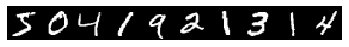

In [12]:
# we use a little trick to tile the first 10 images
imshow(solver.net.blobs['data'].data[:10, 0].transpose(1, 0, 2).reshape(28, 10*28), cmap='gray'); axis('off')
print('train labels:', solver.net.blobs['label'].data[:10])

test labels: [7. 2. 1. 0. 4. 1. 4. 9. 5. 9.]


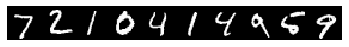

In [13]:
imshow(solver.test_nets[0].blobs['data'].data[:10, 0].transpose(1, 0, 2).reshape(28, 10*28), cmap='gray'); axis('off')
print('test labels:', solver.test_nets[0].blobs['label'].data[:10])

In [14]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print('Iteration', it, 'testing...')
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

I0127 10:19:26.280738  3886 solver.cpp:347] Iteration 0, Testing net (#0)
I0127 10:19:31.419776  4023 data_layer.cpp:73] Restarting data prefetching from start.
I0127 10:19:31.706224  3886 solver.cpp:414]     Test net output #0: loss = 2.48292 (* 1 = 2.48292 loss)
I0127 10:19:31.814652  3886 solver.cpp:239] Iteration 0 (-9.41176e-34 iter/s, 5.535s/100 iters), loss = 2.60473
I0127 10:19:31.814703  3886 solver.cpp:258]     Train net output #0: loss = 2.60473 (* 1 = 2.60473 loss)
I0127 10:19:31.814719  3886 sgd_solver.cpp:112] Iteration 0, lr = 0.01


Iteration 0 testing...


I0127 10:19:37.610553  4023 data_layer.cpp:73] Restarting data prefetching from start.


Iteration 25 testing...


I0127 10:19:47.540189  4023 data_layer.cpp:73] Restarting data prefetching from start.
I0127 10:19:50.613205  3886 solver.cpp:464] Snapshotting to binary proto file mnist/lenet_iter_50.caffemodel
I0127 10:19:50.624121  3886 sgd_solver.cpp:284] Snapshotting solver state to binary proto file mnist/lenet_iter_50.solverstate


Iteration 50 testing...


I0127 10:19:55.312238  4023 data_layer.cpp:73] Restarting data prefetching from start.


Iteration 75 testing...


I0127 10:20:03.044142  4023 data_layer.cpp:73] Restarting data prefetching from start.
I0127 10:20:06.991991  3886 solver.cpp:464] Snapshotting to binary proto file mnist/lenet_iter_100.caffemodel
I0127 10:20:07.004500  3886 sgd_solver.cpp:284] Snapshotting solver state to binary proto file mnist/lenet_iter_100.solverstate
I0127 10:20:07.171696  3886 solver.cpp:239] Iteration 100 (2.82837 iter/s, 35.356s/100 iters), loss = 0.254028
I0127 10:20:07.171743  3886 solver.cpp:258]     Train net output #0: loss = 0.254028 (* 1 = 0.254028 loss)
I0127 10:20:07.171752  3886 sgd_solver.cpp:112] Iteration 100, lr = 0.00992565


Iteration 100 testing...


I0127 10:20:12.662381  4023 data_layer.cpp:73] Restarting data prefetching from start.


Iteration 125 testing...


I0127 10:20:22.332993  4023 data_layer.cpp:73] Restarting data prefetching from start.
I0127 10:20:26.899106  3886 solver.cpp:464] Snapshotting to binary proto file mnist/lenet_iter_150.caffemodel
I0127 10:20:26.908051  3886 sgd_solver.cpp:284] Snapshotting solver state to binary proto file mnist/lenet_iter_150.solverstate


Iteration 150 testing...


I0127 10:20:31.857827  4023 data_layer.cpp:73] Restarting data prefetching from start.


Iteration 175 testing...


I0127 10:20:40.879956  4023 data_layer.cpp:73] Restarting data prefetching from start.


CPU times: user 1min 42s, sys: 31.6 s, total: 2min 14s
Wall time: 1min 18s


I0127 10:20:44.452704  3886 solver.cpp:464] Snapshotting to binary proto file mnist/lenet_iter_200.caffemodel
I0127 10:20:44.464092  3886 sgd_solver.cpp:284] Snapshotting solver state to binary proto file mnist/lenet_iter_200.solverstate


Text(0.5, 1.0, 'Test Accuracy: 0.93')

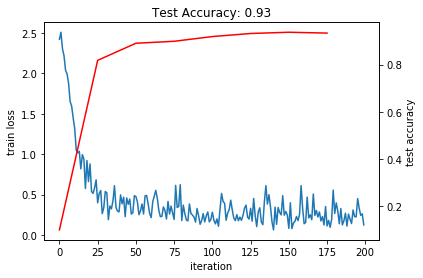

In [17]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

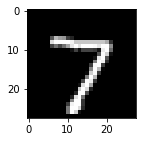

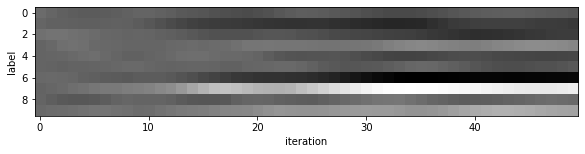

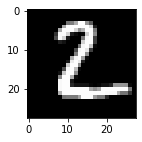

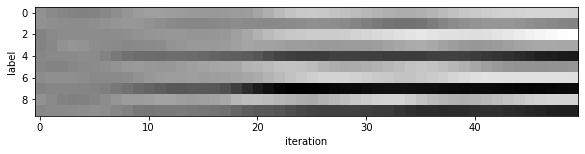

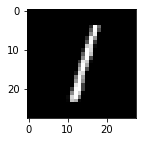

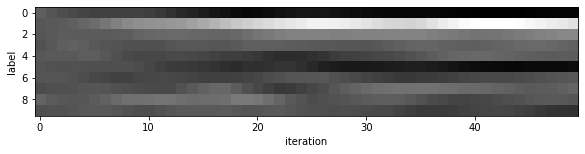

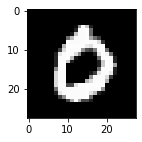

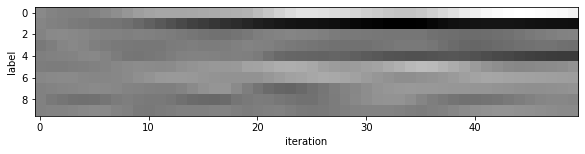

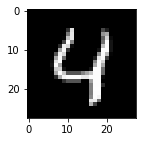

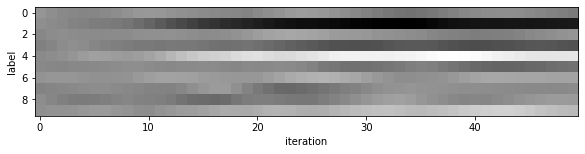

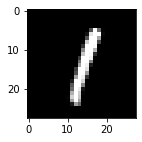

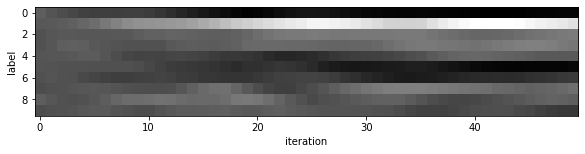

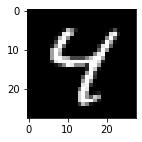

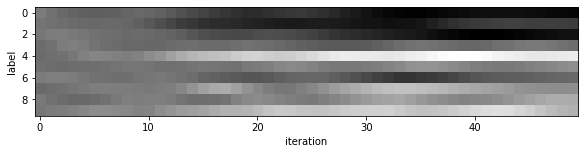

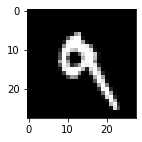

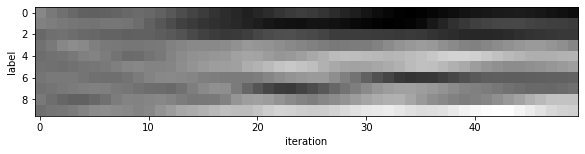

In [18]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

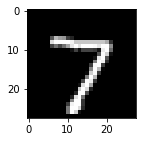

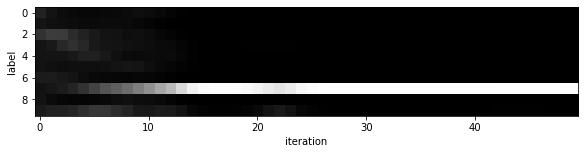

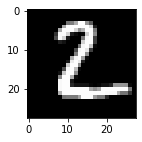

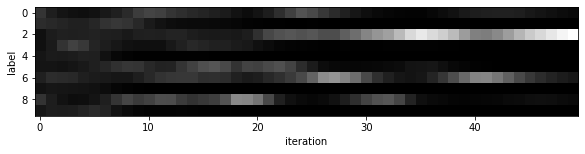

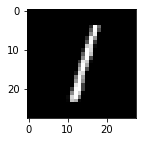

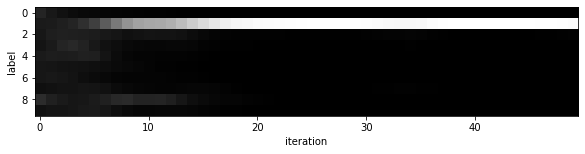

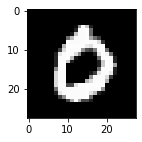

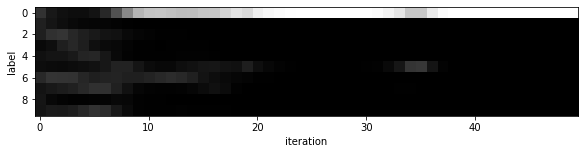

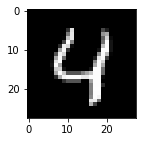

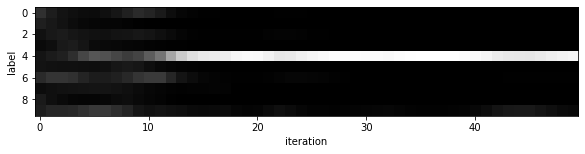

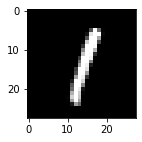

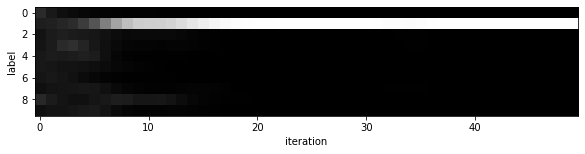

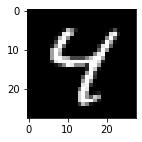

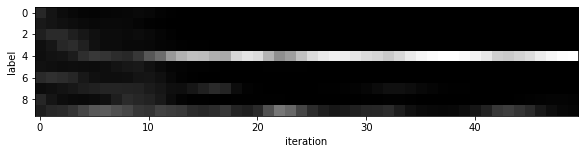

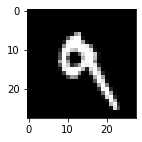

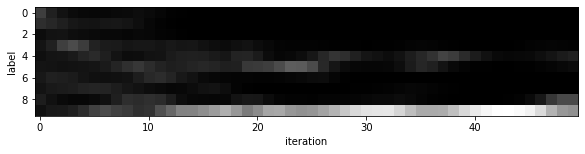

In [19]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')